In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

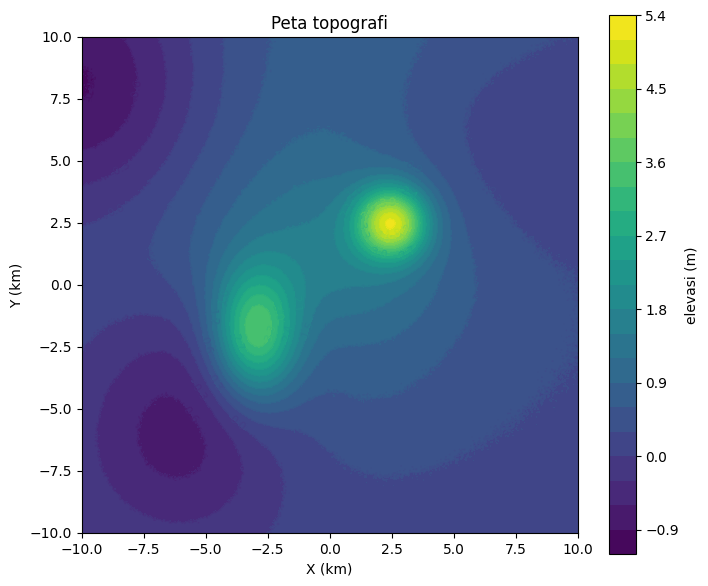

In [3]:
NPM=90
np.random.seed(NPM)

# grid
nx, ny = 400, 400
x = np.linspace(-10, 10, nx)
y = np.linspace(-10, 10, ny)
X, Y = np.meshgrid(x, y)

# puncak/lembah berdasarkan fungsi eksponen
# x0, y0: posisi
# sx, sy: sebaran lelehan tumpengnya
# amp   : amplitudo
def peak(x0, y0, sx, sy, amp):
    return amp * np.exp(-(((X - x0)**2) / (2*sx**2) + ((Y - y0)**2) / (2*sy**2)))

Z = peak(-3, -2, 1.2, 1.8, 3.2) + peak(2.5, 2.5, 1.0, 1.0, 4) + peak(0, 0, 3.5, 3.5, 1.2) \
    + peak(6, 6, 4, 4, -0.6)  + peak(-10, 8, 3.5, 3.5, -1.2) +  peak(-6, -6, 3, 3, -1.0) \
    + peak(-2, -2, 4, 2, -0.6)  + peak(2.5, 9.5, 6, 6, 0.75)

# exponential decay seperti global slope 
Z += 0.5 * np.exp(-(np.sqrt((X/20)**2 + (Y/10)**2)))

# variasi ripple kontur (acak)
Z += 0.01 * np.random.randn(*Z.shape)

# plot
fig, ax = plt.subplots(figsize=(8, 7))
levels = 20  # number of contour levels
cf = ax.contourf(X, Y, Z, levels=levels)
cs = ax.contour(X, Y, Z, levels=levels, linewidths=0.6)
ax.clabel(cs, fmt="%.1f", fontsize=8)
ax.set_title("Peta topografi")
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_aspect('equal', adjustable='box')
plt.colorbar(cf, ax=ax, label="elevasi (m)")

# Bayangkan peta ini adalah topografi bukit di suatu daerah
# 
# 1) cari titik tertinggi global  (bobot 10%)
#   gunakan metode optimasi titik maksimum
# 
# 2) cari titik aliran 'sungai' menuju titik terendah, asumsikan jika 'hujan' langsung mengalir dan tidak terserap ke tanah (bobot 25%)
#   gunakan metode optimasi titik minimum yang 'bertahap' mengalir atau melompat
#   jalankan beberapa kali untuk melihat agregasi aliran pencarian tsb, visualisasikan
#
# 3) kerawanan erosi ditentukan oleh kecuraman lereng, hitung skor kerawanan di tiap titik (bobot 25%) 
#   hitung dengan turunan pertama kontur topologi, boleh gunakan np.gradient() 
#   nilai plus yang menggunakan fungsi numerik racikan sendiri untuk turunan parsialnya, yang kemudian dihitung resultannya
# 
# 4a) jika tanah hendak diratakan, berapa banyak volume tanah yang harus dipindahkan? (dipotong dari puncak dan diurug ke lembah) (bobot 20+5%)
#   hitung dengan integral untuk sisi atas dan sisi bawah
# 4b) berapa ketinggian akhir tanah yang rata tersebut?
#
# Bonus (15%)
#   pembahasan/diskusi yang kritis atau visualisasi yang ciamik (fancy, padat informasi, tapi tidak menyesatkan)
#   pengerjaan yang gercep (2 poin per hari lebih cepat dari 14 Oktober, penalti 2% per hari sejak 15 Oktober jika terlambat)
# 
# Sanksi
# mahasiswa yang terindikasi saling mencontek akan disyaratkan untuk mencantumkan prompt/diskusi dengan LLM (ChatGPT, Gemini, Claude, dlsb) sebagai bukti tidak saling mencontek. 
# Kalau ketahuan memang saling mencontek, nilai terendah dari gerombolan tersebut atau nilai tertinggi – 15 akan diberikan, whichever lowest.

### 1. Gunakan metode optimasi titik maksimum

          X: 2.4500 km,          Y: 2.4500 km,          Z: 5.1939    
          X: -1.6500 km,          Y: -2.9500 km,          Z: 3.5947    


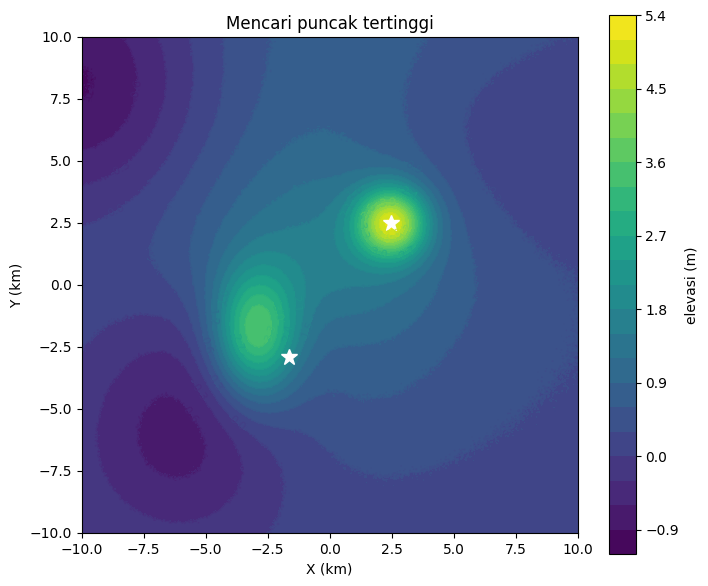

In [4]:
def find_max_position(start_x, start_y):
    final_x, final_y = start_x, start_y
    max_Z = Z[start_x][start_y]
    new_Z = True
    while new_Z:
        new_Z = False
        new_ix, new_iy = 0, 0

        # Mencari max di kotak 21x21
        for ix in range(-10, 20):
            for iy in range(-10, 20):
                if 0 <= final_x + ix < nx and 0 <= final_y + iy < ny:
                    if max_Z < Z[final_x + ix][final_y + iy]:
                        max_Z = Z[final_x + ix][final_y + iy]
                        new_Z = True
                        new_ix, new_iy = ix, iy
        final_x += new_ix
        final_y += new_iy
    return (
        final_x,
        final_y,
        max_Z
    )

fig, ax = plt.subplots(figsize=(8, 7))
cf = ax.contourf(X, Y, Z, levels=levels)
cs = ax.contour(X, Y, Z, levels=levels, linewidths=0.6)
ax.clabel(cs, fmt="%.1f", fontsize=8)
ax.set_title("Mencari puncak tertinggi")
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_aspect('equal', adjustable='box')
plt.colorbar(cf, ax=ax, label="elevasi (m)")

max_values = []
for _ in range(169):
    a = find_max_position(random.randint(0, nx-1), random.randint(0, ny-1))
    if a[2] not in max_values:
        max_values.append(a[2])
    else:
        continue
    print(f"\
          X: {a[0]/nx*20-10:.4f} km,\
          Y: {a[1]/ny*20-10:.4f} km,\
          Z: {a[2]:.4f}\
    ")
    plt.plot(x[a[0]], x[a[1]], color="white", marker="*", markersize=12)



Setelah di-run beberapa kali, didapat ketinggian maxnya konsisten di ~5.2000 m di X = 2.45 km dan Y = 2.45 km.

Kalau tidak percaya silakan di-run sendiri lagi.

### 2. Cari titik aliran 'sungai' menuju titik terendah, asumsikan jika 'hujan' langsung mengalir dan tidak terserap ke tanah

          X: 5.2381 km,          Y: 8.9975 km,          Z: 0.1185    
          X: 8.2456 km,          Y: -9.9499 km,          Z: -0.9371    
          X: -5.8396 km,          Y: -6.4411 km,          Z: -0.7375    
          X: -6.2406 km,          Y: -6.3910 km,          Z: -0.7384    
          X: -4.2857 km,          Y: 9.9499 km,          Z: 0.2573    
          X: -5.2381 km,          Y: 10.0000 km,          Z: 0.2316    
          X: -5.9398 km,          Y: 9.9499 km,          Z: 0.2189    
          X: 5.8396 km,          Y: 9.6992 km,          Z: 0.1241    
          X: 6.3910 km,          Y: 8.0451 km,          Z: 0.1187    
          X: -6.2406 km,          Y: 6.8922 km,          Z: 0.2497    
          X: 0.9774 km,          Y: 9.9499 km,          Z: 0.2446    
          X: -6.2406 km,          Y: -6.0401 km,          Z: -0.7323    
          X: -5.9398 km,          Y: 9.2982 km,          Z: 0.2234    
          X: 6.9424 km,          Y: 8.3960 km,          Z: 0.1356    
   

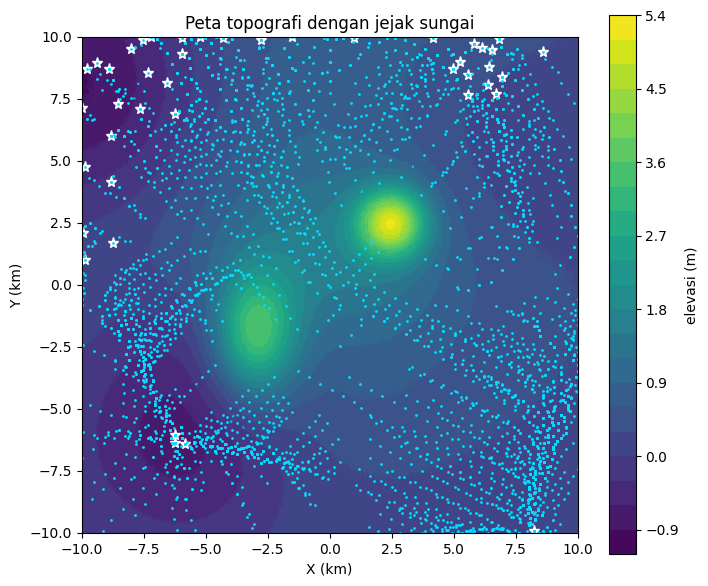

In [5]:
river_points = []
def find_min_position(start_x, start_y):
    final_x, final_y = start_x, start_y
    min_Z = Z[start_x][start_y]
    new_Z = True
    while new_Z:
        new_Z = False
        new_ix, new_iy = 0, 0
        river_points.append((final_x, final_y))
        # Mencari min di kotak 11x11
        for ix in range(-5, 10):
            for iy in range(-5, 10):
                # menggambar sungai
                
                if 0 <= final_x + ix < nx and 0 <= final_y + iy < ny:
                    if min_Z > Z[final_x + ix][final_y + iy]:
                        min_Z = Z[final_x + ix][final_y + iy]
                        new_Z = True
                        new_ix, new_iy = ix, iy
        final_x += new_ix
        final_y += new_iy
    return (
        final_x,
        final_y,
        min_Z
    )

fig, ax = plt.subplots(figsize=(8, 7))
cf = ax.contourf(X, Y, Z, levels=levels)
cs = ax.contour(X, Y, Z, levels=levels, linewidths=0.6)
ax.clabel(cs, fmt="%.1f", fontsize=8)
ax.set_title("Peta topografi dengan jejak sungai")
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_aspect('equal', adjustable='box')
plt.colorbar(cf, ax=ax, label="elevasi (m)")

min_values = []
for _ in range(400):
    a = find_min_position(random.randint(0, nx-1), random.randint(0, ny-1))
    if a[2] not in min_values:
        min_values.append(a[2])
    else:
        continue
    print(f"\
          X: {x[a[0]]:.4f} km,\
          Y: {y[a[1]]:.4f} km,\
          Z: {a[2]:.4f}\
    ")
    plt.plot(x[a[0]], y[a[1]], color="white", marker="*", markersize=8)
print(river_points)
for i in river_points:
    plt.plot(x[i[0]], y[i[1]], color="#03ddff", marker=".", markersize=2)

### 3. Kerawanan erosi ditentukan oleh kecuraman lereng, hitung skor kerawanan di tiap titik

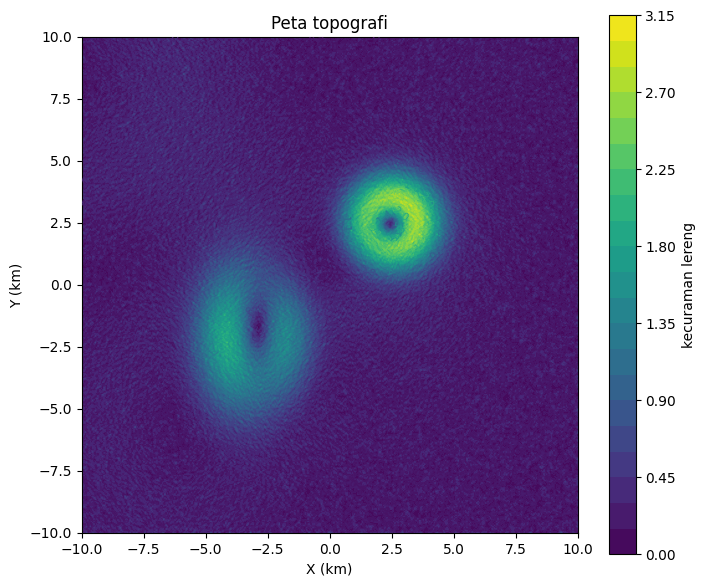

In [6]:
def two_dim_derv(Z, dx, dy):
    dZdx = np.zeros(Z.shape)
    dZdy = np.zeros(Z.shape)
    
    for i in range(Z.shape[0]):
        for j in range(1, Z.shape[1]-1):
            dZdx[i][j] = (Z[i][j+1] - Z[i][j-1]) / (2*dx)
        dZdx[i][0] = (Z[i][1] - Z[i][0]) / dx
        dZdx[i][-1] = (Z[i][-1] - Z[i][-2]) / dx
    for j in range(Z.shape[1]):
        for i in range(1, Z.shape[0]-1):
            dZdy[i][j] = (Z[i+1][j] - Z[i-1][j]) / (2*dy)
        dZdy[0][j] = (Z[1][j] - Z[0][j]) / dy
        dZdy[-1][j] = (Z[-1][j] - Z[-2][j]) / dy

    return dZdx, dZdy
dx = x[1] - x[0]
dy = y[1] - y[0]
dZdx, dZdy = two_dim_derv(Z, dx, dy)


Z_2 = np.sqrt(dZdx**2 + dZdy**2)

fig, ax = plt.subplots(figsize=(8, 7))
cf = ax.contourf(X, Y, Z_2, levels=levels)
cs = ax.contour(X, Y, Z_2, levels=levels, linewidths=0.6)
ax.clabel(cs, fmt="%.1f", fontsize=8)
ax.set_title("Peta topografi")
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_aspect('equal', adjustable='box')
plt.colorbar(cf, ax=ax, label="kecuraman lereng")

### 4. Jika tanah hendak diratakan, berapa banyak volume tanah yang harus dipindahkan? (dipotong dari puncak dan diurug ke lembah)

In [8]:
def targeted_height_calculate_volume(Z, target_height, dx, dy, partial=False):
    uppervolume = 0
    lowervolume = 0
    volume = 0
    for i in range(Z.shape[0]-1):
        for j in range(Z.shape[1]-1):
            if Z[i][j] > target_height:
                uppervolume += (Z[i][j] - target_height) * dx * dy
            else:
                lowervolume += (target_height - Z[i][j]) * dx * dy
    if partial:
        return uppervolume, lowervolume
    else:
        return uppervolume - lowervolume
def sci_notation(x):
    if x == 0:
        exponent = 0
    else:
        exponent = int(math.floor(math.log10(abs(x))))
    mantissa = x / (10 ** exponent)
    if exponent < 3 and exponent > -3:
        return f"{x:.4f}"
    else:
        return f"{mantissa:.8f}e{exponent}"
for i in range(20+1):
    h = 0.502815819 - 1e-9*(i-10)
    uv, lv = targeted_height_calculate_volume(Z, h, dx, dy, partial=True)
    print(f" \
        Ketinggian target: {h:.9f} m \
        Volume atas: {sci_notation(1e6*uv)} m^3 \
        Volume bawah: {sci_notation(1e6*lv)} m^3\
        Selisih: {sci_notation(1e6*(uv-lv))} m^3\
    ")

         Ketinggian target: 0.502815829 m         Volume atas: 1.09453046e8 m^3         Volume bawah: 1.09453050e8 m^3        Selisih: -3.8510 m^3    
         Ketinggian target: 0.502815828 m         Volume atas: 1.09453046e8 m^3         Volume bawah: 1.09453050e8 m^3        Selisih: -3.4510 m^3    
         Ketinggian target: 0.502815827 m         Volume atas: 1.09453046e8 m^3         Volume bawah: 1.09453049e8 m^3        Selisih: -3.0510 m^3    
         Ketinggian target: 0.502815826 m         Volume atas: 1.09453047e8 m^3         Volume bawah: 1.09453049e8 m^3        Selisih: -2.6510 m^3    
         Ketinggian target: 0.502815825 m         Volume atas: 1.09453047e8 m^3         Volume bawah: 1.09453049e8 m^3        Selisih: -2.2510 m^3    
         Ketinggian target: 0.502815824 m         Volume atas: 1.09453047e8 m^3         Volume bawah: 1.09453049e8 m^3        Selisih: -1.8510 m^3    
         Ketinggian target: 0.502815823 m         Volume atas: 1.09453047e8 m^3         Volume

Jika hendak meratakan medan, maka harus menggali semua tanah dari ketinggian di atas kurang lebih 0.502815819 m lalu dituangkan semua galiannya ke lembah. Setelah diratakan seharusnya ketinggian akhirnya 0.502815819 m.

Volume tanah yang harus diurug adalah ~$1.094e8 \cdot 10^8$ $m^3$ (109.453.058)